## Computing the TF-IDF using Spark and Python

Database management project 


Objective of the session:
    - Check evolution of TF IDF scores as size increase
    - Write a lot about algorithm

Question to ask:
    - is it smart to use collect as map () vs. Collect()

### Setting the workspace - for jupyter notbook only

In [102]:
from pyspark import SparkConf, SparkContext
import numpy as np

In [5]:
conf = SparkConf().setMaster("local[1]").setAppName("SparkTFIDF")
sc = SparkContext(conf=conf)

### Loading and clearing data

In [6]:
data_text_files = sc.wholeTextFiles("bbc/business/", 8) #loading sets of files in the folder bbc


In [6]:
nb_doc = data_text_files.count() #counting the number of files

In [7]:
print(nb_doc)

510


In [9]:
#cleaning function - remove digits and punctuation and put everything in lowercase
def lower_clean_str(x):
  punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
  digit='0123456789'
  lowercased_str = x.lower()
  
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  for dig in digit:
    lowercased_str = lowercased_str.replace(dig, '')
  return lowercased_str.replace('\n', '')


In [177]:
#Function removing stopwords
def stopword(x):
    stopwords= ['a','able','about','across','after','all','almost','also','am','among','an','and','any','are','as','at','be','because','been','but','by',
            'can','cannot','could','dear','did','do','does','either','else','ever','every','for','from','get','got','had','has','have','he','her','hers',
            'him','his','how','however','i','if','in','into','is','it','its','just','least','let','like','likely','may','me','might','most','must','my',
            'neither','no','nor','not','of','off','often','on','only','or','other','our','own','rather','said','say','says','she','should','since','so',
            'some','than','that','the','their','them','then','there','these','they','this','tis','to','too','twas','us','wants','was','we','were','what',
            'when','where','which','while','who','whom','why','will','with','would','yet','you','your' 'bn','£bn', 'see','£m']
    
    x = [ value for value in x if value not in stopwords]
    return x


In [10]:
data_text_cleared = data_text_files.mapValues(lower_clean_str)

In [11]:
#tf part - count number of word occurence in each doc
split_data = data_text_cleared.mapValues(lambda x: x.split()) #first, we split the data at every ' '



In [196]:
split_data_cleared = split_data.mapValues(stopword)

### TF computation

In [188]:
term_freq = split_data.flatMapValues(lambda x: x).map(lambda x: ((x[0],x[1]), 1)) #apply a flatmap 
# and create a map with key (filename, word) and value 1

In [14]:
rdd_term_freq = term_freq.reduceByKey(lambda x,y: x+y) #output is a RDD with Key (Title, word) and Value: nb_occurence

### IDF computation

In [15]:
#count number of document occurence of each word
doc_freq = split_data.flatMapValues(lambda x: x).distinct() # get (file, word) for evry time a word is inside a doc
idf_dict = doc_freq.map(lambda x: (x[1],x[0])).countByKey() # invert key value in the dictionnary for later - output is a dict as we apply the action .countByKey

In [16]:
idf_rdd = doc_freq.map(lambda x: (x[1],1)).reduceByKey(lambda x,y: x+y) #we have a similar output as in idf_dict but with a rdd 
 

### (1) TF-IDF computation: putting everything together - with Broadcast dict

In [35]:
idf_score = sc.broadcast(dict(idf_dict)) #using broadcasting variable for a map join 

# Creaing a RDD with key (file, word) and value (tf, idf)
tf_idf_raw = rdd_term_freq.map(lambda x: ((x[0][0],x[0][1]), (x[1], idf_score.value[x[0][1]])))


In [44]:
tf_idf_dict = tf_idf_raw.map(lambda x: (x[0], (x[1][0]/x[1][1]))) #get the tf-idf

In [45]:
tf_idf_dict_broadcast = tf_idf_dict.collectAsMap() #RDD as a dict

### (2) TF-IDF computation: putting everything together - with RDD join

In [33]:
#using Spark join, we first need to change the Key of rdd_term_freq to have key: Word and value: (file, nb_occurence)
joined_rdd = rdd_term_freq.map(lambda x: ((x[0][1]), (x[0][0], x[1]))).join(idf_rdd)
#output is rdd (word, (( file, tf), rdf))


In [54]:
tf_idf_dict_join = joined_rdd.map(lambda x: ((x[1][0][0], x[0]) , x[1][0][1]/x[1][1])).collectAsMap()

### Scalability Analysis

##### Brodcasted dict size as fonction of nb of documents

THe aim is to create a fonction that gets the first n file in the list and then run an idf on them, then compare the size of the dict as a fonction of the nb of file

I'd expect a log shaped size, which would be good to justify use of broadcast variable

In [133]:
test = sc.wholeTextFiles("bbc/business/", 8) #loading sets of files in the folder bbc


In [180]:

def nb_value_generator(x, stop_bool = False):
    global test
    doc = test.sample(True, x)
    nb_doc = doc.count()


    clean_rdd = doc.mapValues(lower_clean_str)
    splitted_rdd = clean_rdd.mapValues(lambda x: x.split())
    while stop_bool:
        splitted_rdd = splitted_rdd.mapValues(stopword)
        stop_bool = False
    idf_rdd = splitted_rdd.flatMapValues(lambda x: x).distinct() # get (file, word) for evry time a word is inside a doc
    idf_dict_nb = idf_rdd.map(lambda x: (x[1],x[0])).countByKey()
    
    nb_word=0
    for elem in idf_dict_nb:
        nb_word += 1
    return (nb_doc, nb_word)



In [183]:
nb_value_generator(0.02, True)

(15, 1441)

In [184]:

words_nb=[]
docs_nb=[]

words_nb_clean=[]
docs_nb_clean=[]

for i in np.linspace(0.01,1,25):
    yolo = nb_value_generator(i)
    yolo_clean = nb_value_generator(i, True)
    docs_nb.append(yolo[0])
    words_nb.append(yolo[1])
    docs_nb_clean.append(yolo_clean[0])
    words_nb_clean.append(yolo_clean[1])

    

In [185]:
print(words_nb, docs_nb)

[513, 1889, 3262, 3815, 5092, 5786, 5751, 6278, 6828, 6682, 7612, 8067, 7860, 9011, 8386, 9074, 9196, 9009, 9884, 9976, 9962, 9974, 10374, 10433, 10616] [4, 22, 52, 61, 94, 134, 127, 145, 160, 168, 206, 235, 238, 301, 280, 332, 340, 336, 396, 430, 418, 453, 465, 485, 499]


<function matplotlib.pyplot.show(*args, **kw)>

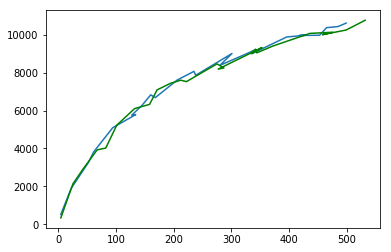

In [187]:
import matplotlib.pyplot as plt




plt.plot(docs_nb, words_nb)
plt.plot(docs_nb_clean, words_nb_clean, color = "g")
plt.show


#could make them look nicer

##### Distibution of IDF score as fonction of nb of doc